In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc

2025-03-05 15:41:59.192193: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 15:41:59.213931: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 15:41:59.241731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 15:41:59.249767: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 15:41:59.272426: I tensorflow/core/platform/cpu_feature_guar

In [2]:
model_info = {
    # 64×64
    "best_64_64_cnn.keras": {
        "image_size": (64, 64),
        "plot_title": "Best Custom CNN (Downsized Image)",
    },
    "second_best_64_64_cnn.keras": {
        "image_size": (64, 64),
        "plot_title": "Second Best Custom CNN (Downsized Image)",
    },
    # 256×256
    "best_model_256_256.keras": {
        "image_size": (256, 256),
        "plot_title": "Best Custom CNN (Full Image)",
    },
    "second_best_model_256_256.keras": {
        "image_size": (256, 256),
        "plot_title": "Second Best Custom CNN (Full Image)",
    },
    # EfficientNet & VGG (224×224, adjust if needed)
    "efficient_net.keras": {"image_size": (128, 128), "plot_title": "Efficient Net"},
    "vgg_19_net.keras": {"image_size": (128, 128), "plot_title": "VGG-19"},
}

In [3]:
def create_validation_dataset(val_dir, image_size=(64, 64), batch_size=32):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        val_dir,
        labels="inferred",
        label_mode="binary",
        batch_size=batch_size,
        image_size=image_size,
        shuffle=False,
    )
    y_true = np.concatenate([y.numpy() for x, y in ds], axis=0)
    return ds, y_true

In [ ]:
def evaluate_model(model_path, ds, y_true, plot_title):
    """
    Loads a .keras model from 'model_path',
    predicts on 'ds', and prints Accuracy, F1, and ROC AUC.
    Also plots the ROC curve.
    """
    model = tf.keras.models.load_model(model_path)

    # For a single-sigmoid output (binary classification)
    y_pred_prob = model.predict(ds).flatten()
    y_pred = (y_pred_prob >= 0.5).astype(int)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f"--- Evaluating: {model_path} ---")
    print("Accuracy:", acc)
    print("F1 Score:", f1)
    print("ROC AUC:", roc_auc)
    print()

    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve - {plot_title}")
    plt.legend()
    plt.grid()
    plt.show()

Found 10905 files belonging to 2 classes.
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
--- Evaluating: ../../../shared/spotlight/models/best_64_64_cnn.keras ---
Accuracy: 0.8327372764786795
F1 Score: 0.8447395301327886
ROC AUC: 0.8386109099926549



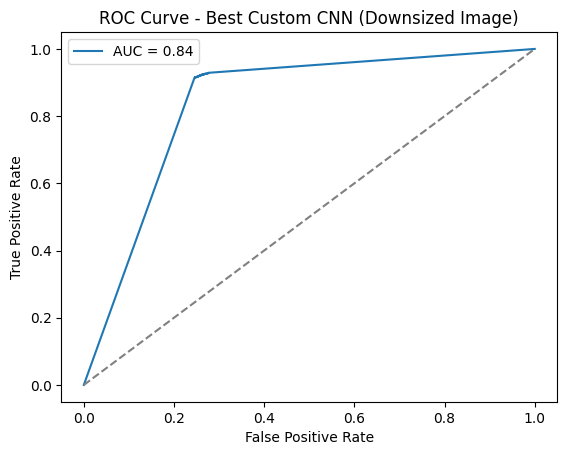

341/341 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
--- Evaluating: ../../../shared/spotlight/models/second_best_64_64_cnn.keras ---
Accuracy: 0.8420907840440165
F1 Score: 0.8375778155065082
ROC AUC: 0.881191193034384



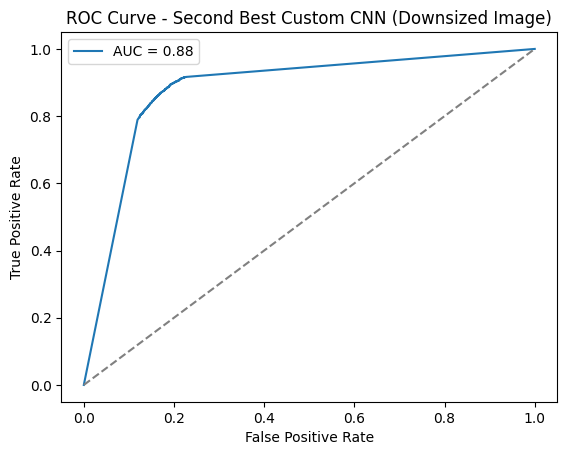

Found 10905 files belonging to 2 classes.
341/341 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step
--- Evaluating: ../../../shared/spotlight/models/best_model_256_256.keras ---
Accuracy: 0.7830353049060064
F1 Score: 0.7869236311239193
ROC AUC: 0.8040930065181215



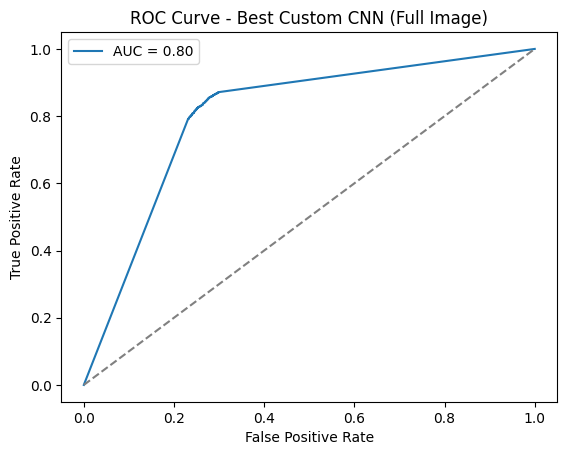

341/341 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
--- Evaluating: ../../../shared/spotlight/models/second_best_model_256_256.keras ---
Accuracy: 0.7480972031178359
F1 Score: 0.7537427162707306
ROC AUC: 0.8131888830388496



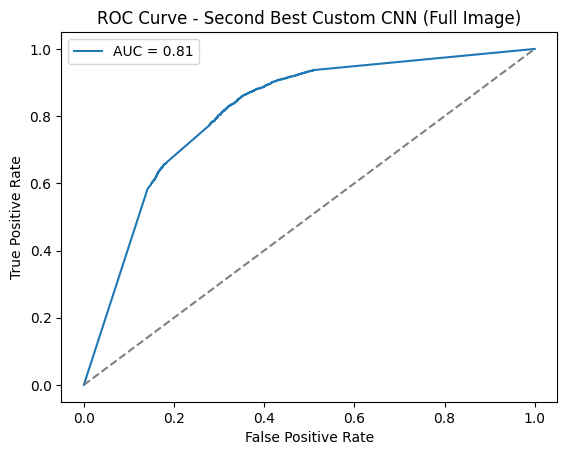

Found 10905 files belonging to 2 classes.
341/341 ━━━━━━━━━━━━━━━━━━━━ 72s 114ms/step
--- Evaluating: ../../../shared/spotlight/models/efficient_net.keras ---
Accuracy: 0.5005043558000917
F1 Score: 0.5234887586387893
ROC AUC: 0.49817987610146275



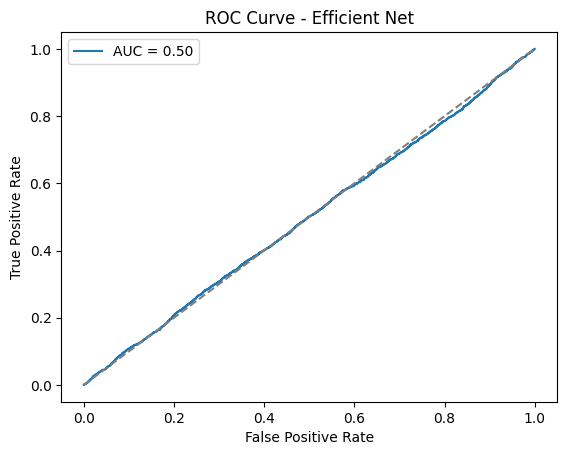

341/341 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step
--- Evaluating: ../../../shared/spotlight/models/vgg_19_net.keras ---
Accuracy: 0.7352590554791381
F1 Score: 0.7507984462667242
ROC AUC: 0.7487456689265639



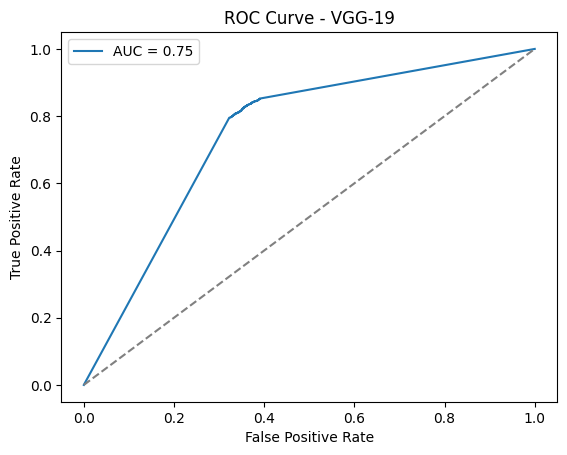

In [ ]:
val_dir = "path/to/test/images"

dataset_cache = {}  # key: (width, height) -> (ds, y_val)

for model_name, info in model_info.items():
    img_size = info["image_size"]

    # Check if we already created a dataset for this size
    if img_size not in dataset_cache:
        val_ds, y_val = create_validation_dataset(
            val_dir=val_dir, image_size=img_size, batch_size=32
        )
        # Optionally cache/prefetch
        val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
        dataset_cache[img_size] = (val_ds, y_val)

    ds, y_true = dataset_cache[img_size]

    model_path = f"..models/{model_name}"
    # ^ Adjust if your .keras files are in a different location or use absolute paths if needed

    evaluate_model(model_path, ds, y_true, info["plot_title"])